Group Members: John Chen, Jing Yu

## Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from wordcloud import WordCloud
from nltk.stem.porter import *
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, roc_curve
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import LatentDirichletAllocation
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from numpy import random
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Part 1

Reading in datasets

In [ ]:
corona_train = pd.read_csv('https://raw.githubusercontent.com/jchenDDD/assignment_4_data/main/Corona_NLP_train.csv',encoding='ISO-8859-1')
corona_test = pd.read_csv('https://raw.githubusercontent.com/jchenDDD/assignment_4_data/main/Corona_NLP_test.csv')

In [ ]:
corona_train['OriginalTweet']

0        @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...
1        advice Talk to your neighbours family to excha...
2        Coronavirus Australia: Woolworths to give elde...
3        My food stock is not the only one which is emp...
4        Me, ready to go at supermarket during the #COV...
                               ...                        
41152    Airline pilots offering to stock supermarket s...
41153    Response to complaint not provided citing COVI...
41154    You know itÂs getting tough when @KameronWild...
41155    Is it wrong that the smell of hand sanitizer i...
41156    @TartiiCat Well new/used Rift S are going for ...
Name: OriginalTweet, Length: 41157, dtype: object

A. Class proportions

In [ ]:
corona_train.Sentiment.unique()

array(['Neutral', 'Positive', 'Extremely Negative', 'Negative',
       'Extremely Positive'], dtype=object)

In [ ]:
def changeLabel(s):
  if (s == "Negative") | (s == "Extremely Negative"):
    return 0
  elif (s == "Neutral"):
    return 1
  elif (s == "Positive") | (s == "Extremely Positive"):
    return 2
  return -1

corona_train['Sentiment'] = corona_train['Sentiment'].apply(lambda row: changeLabel(row))
corona_test['Sentiment'] = corona_test['Sentiment'].apply(lambda row: changeLabel(row))

In [ ]:
positive_count = len(corona_train[corona_train["Sentiment"]== 2])
neutral_count = len(corona_train[corona_train["Sentiment"]== 1])
negative_count = len(corona_train[corona_train["Sentiment"]== 0])
print("positive ratio: ", positive_count/len(corona_train) * 100)
print("neutral ratio: ", neutral_count/len(corona_train) * 100)
print("negative ratio: ", negative_count/len(corona_train) * 100)

positive ratio:  43.84673324100396
neutral ratio:  18.740432976164442
negative ratio:  37.4128337828316


B. Tokenize the tweets

In [ ]:
def tokenize(df, column):
  df['tokens'] = df[column].apply(lambda row: row.split())

tokenize(corona_train, "OriginalTweet")
tokenize(corona_test, "OriginalTweet")

C. Remove any URL tokens

In [ ]:
def remove_URL(df):
  df['tokens'] = df['tokens'].apply(lambda row: [token for token in row if not re.match(r'http\S+', token)])

remove_URL(corona_train)
remove_URL(corona_test)

D. Remove all punctuations and special characters and convert tokens into lowercase

In [ ]:
def remove_punc(df):
  df['tokens'] = df['tokens'].apply(lambda row: [re.sub(r'[^\w\s]','', token) for token in row if not re.match(r'[^\w\s]', token)])

def lowercase(df):
  df['tokens'] = df['tokens'].apply(lambda row: [token.lower() for token in row])

remove_punc(corona_train)
lowercase(corona_train)
remove_punc(corona_test)
lowercase(corona_test)

E. Stemming tokens

In [ ]:
# Using the Porter stemmer
def stem(df):
  stemmer = PorterStemmer()
  df['tokens'] = df['tokens'].apply(lambda row: [stemmer.stem(w) for w in row])

stem(corona_train)
stem(corona_test)

F. Remove stopwords

In [ ]:
def remove_stopwords(df):
  sw = stopwords.words("english")[:100]
  df['tokens'] = df['tokens'].apply(lambda row: [w for w in row if w not in sw])

nltk.download('stopwords')
remove_stopwords(corona_train)
remove_stopwords(corona_test)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


G.Convert to word count vector

In [ ]:
def override_fcn(doc):
  # We expect a list of tokens as input
  return doc

def count_vector(X_train, X_test):
  count_vec = CountVectorizer(
      analyzer='word',
      tokenizer= override_fcn,
      preprocessor= override_fcn,
      token_pattern= None,
      max_features = 11000)

  counts_train = count_vec.fit_transform(X_train)
  counts_test = count_vec.transform(X_test)
  print("Matrix of counts for training data:\n", counts_train.toarray())
  print("Matrix of counts for testing data:\n", counts_test.toarray())
  print("Vocabulary length:", len(count_vec.vocabulary_))
  return count_vec, counts_train, counts_test

In [ ]:
# Convert lists of words to count vector
X_train, y_train = corona_train['tokens'].to_numpy(), corona_train['Sentiment'].to_numpy()
X_test, y_test = corona_test['tokens'].to_numpy(), corona_test['Sentiment'].to_numpy()

count_vec, counts_train, counts_test = count_vector(X_train, X_test)

Matrix of counts for training data:
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Matrix of counts for testing data:
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Vocabulary length: 11000


H. Fit a Naive Bayes Model. Find the top 5 most probable words in each class.

In [ ]:
# Fit model on training data
nb_model = MultinomialNB(alpha=1).fit(counts_train, y_train)

# Predict labels for both training and testing data
train_preds = nb_model.predict(counts_train)
test_preds = nb_model.predict(counts_test)

# Compute training and testing accuracy
train_acc = accuracy_score(y_train,train_preds)
test_acc = accuracy_score(y_test,test_preds)

print('Train error:', 1-train_acc)
print('Test error:', 1-test_acc)
print('Train accuracy:', train_acc)
print('Test accuracy:', test_acc)

Train error: 0.23677624705396405
Test error: 0.3033175355450237
Train accuracy: 0.763223752946036
Test accuracy: 0.6966824644549763


In [ ]:
def top_five(nb_model, vec, vec_train, class_name):
  for i, class_name in enumerate(class_name):
    prob = np.exp(nb_model.feature_log_prob_[i])
    index = np.argsort(prob)[::-1][:5]
    print("\nTop 5 words for", class_name, ":")
    for j in index:
      print(vec.get_feature_names_out()[j], int(prob[j]*vec_train.sum()))

# find the 5 most probable words in each class, along with their counts
top_five(nb_model, count_vec, counts_train, ['Negative', 'Neutral', 'Positive'])


Top 5 words for Negative :
price 10286
food 8401
thi 7676
covid19 6931
supermarket 6782

Top 5 words for Neutral :
store 10619
covid19 9046
price 8971
supermarket 8944
groceri 8078

Top 5 words for Positive :
store 8023
thi 7799
price 6814
covid19 6603
groceri 6455


I. ROC curve(done in google doc)

J. Convert to TF-IDF vectors

In [ ]:
# Convert lists of words to TF-IDF vectors
def tfidf_vector(X_train, X_test):
  tfidf_vec = TfidfVectorizer(
      analyzer='word',
      tokenizer= override_fcn,
      preprocessor= override_fcn,
      token_pattern= None,
      max_features = 11000)

  tf_train = tfidf_vec.fit_transform(X_train)
  tf_test = tfidf_vec.transform(X_test)
  print("Matrix of counts for training data:\n", tf_train.toarray())
  print("Matrix of counts for testing data:\n", tf_test.toarray())
  print("Vocabulary length:", len(tfidf_vec.vocabulary_))
  return tfidf_vec, tf_train, tf_test

In [ ]:
# Convert lists of words to count vector
X_train, y_train = corona_train['tokens'].to_numpy(), corona_train['Sentiment'].to_numpy()
X_test, y_test = corona_test['tokens'].to_numpy(), corona_test['Sentiment'].to_numpy()

tfidf_vec, tf_train, tf_test = tfidf_vector(X_train, X_test)

Matrix of counts for training data:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Matrix of counts for testing data:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Vocabulary length: 11000


In [ ]:
# Fit model on training data
nb_model2 = MultinomialNB(alpha=1).fit(tf_train, y_train)

# Predict labels for both training and testing data
train_preds2 = nb_model2.predict(tf_train)
test_preds2 = nb_model2.predict(tf_test)

# Compute training and testing accuracy
train_acc2 = accuracy_score(y_train,train_preds2)
test_acc2 = accuracy_score(y_test,test_preds2)

print('Train error:', 1-train_acc2)
print('Test error:', 1-test_acc2)
print('Train accuracy:', train_acc2)
print('Test accuracy:', test_acc2)

Train error: 0.27749835993877103
Test error: 0.33886255924170616
Train accuracy: 0.722501640061229
Test accuracy: 0.6611374407582938


In [ ]:
# find the 5 most probable words in each class, along with their counts
top_five(nb_model2, tfidf_vec, tf_train, ['Negative', 'Neutral', 'Positive'])


Top 5 words for Negative :
price 998
food 899
thi 751
supermarket 712
covid19 704

Top 5 words for Neutral :
store 1056
supermarket 915
groceri 896
covid19 884
price 808

Top 5 words for Positive :
store 848
thi 792
groceri 749
hand 692
supermarket 679


K. Lemmatization and TF-IDF transformers

In [ ]:
# Rereading datasets
corona_train = pd.read_csv('https://raw.githubusercontent.com/jchenDDD/assignment_4_data/main/Corona_NLP_train.csv',encoding='ISO-8859-1')
corona_test = pd.read_csv('https://raw.githubusercontent.com/jchenDDD/assignment_4_data/main/Corona_NLP_test.csv')

# Change label of sentiment
corona_train['Sentiment'] = corona_train['Sentiment'].apply(lambda row: changeLabel(row))
corona_test['Sentiment'] = corona_test['Sentiment'].apply(lambda row: changeLabel(row))

def lemmatization(df):
  lem = WordNetLemmatizer()
  df['tokens'] = df['tokens'].apply(lambda row: [lem.lemmatize(w) for w in row])

tokenize(corona_train, "OriginalTweet")
tokenize(corona_test, "OriginalTweet")
remove_URL(corona_train)
remove_URL(corona_test)
remove_punc(corona_train)
lowercase(corona_train)
remove_punc(corona_test)
lowercase(corona_test)
lemmatization(corona_train)
lemmatization(corona_test)
remove_stopwords(corona_train)
remove_stopwords(corona_test)

In [ ]:
# Convert lists of words to count vector
X_train, y_train = corona_train['tokens'].to_numpy(), corona_train['Sentiment'].to_numpy()
X_test, y_test = corona_test['tokens'].to_numpy(), corona_test['Sentiment'].to_numpy()

tfidf_vec, tf_train, tf_test = tfidf_vector(X_train, X_test)

Matrix of counts for training data:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Matrix of counts for testing data:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Vocabulary length: 11000


In [ ]:
# Fit model on training data
nb_model3 = MultinomialNB(alpha=1).fit(tf_train, y_train)

# Predict labels for both training and testing data
train_preds3 = nb_model3.predict(tf_train)
test_preds3 = nb_model3.predict(tf_test)

# Compute training and testing accuracy
train_acc3 = accuracy_score(y_train,train_preds3)
test_acc3 = accuracy_score(y_test,test_preds3)

print('Train error:', 1-train_acc3)
print('Test error:', 1-test_acc3)
print('Train accuracy:', train_acc3)
print('Test accuracy:', test_acc3)

# find the 5 most probable words in each class, along with their counts
top_five(nb_model3, tfidf_vec, tf_train, ['Negative', 'Neutral', 'Positive'])

Train error: 0.2646208421410695
Test error: 0.32885729331226965
Train accuracy: 0.7353791578589305
Test accuracy: 0.6711427066877304

Top 5 words for Negative :
price 972
food 880
supermarket 699
covid19 691
panic 679

Top 5 words for Neutral :
store 1035
supermarket 901
grocery 881
covid19 858
price 784

Top 5 words for Positive :
store 828
grocery 733
hand 670
supermarket 663
covid19 657


# Part 2

Reading in dataset

In [ ]:
tweets = pd.read_csv('https://raw.githubusercontent.com/jchenDDD/assignment_4_data/main/tweets.csv', index_col=0)

EDA

In [ ]:
tweets.shape # data dimension (n x p)

(10000, 7)

In [ ]:
tweets.info() # print basic info

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   tweet_text             10000 non-null  object
 1   tweet_favourite_count  10000 non-null  int64 
 2   tweet_created_at       10000 non-null  object
 3   tweet_retweet_count    10000 non-null  int64 
 4   user_statuses_count    10000 non-null  int64 
 5   user_screen_name       10000 non-null  object
 6   user_followers_count   10000 non-null  int64 
dtypes: int64(4), object(3)
memory usage: 625.0+ KB


In [ ]:
tweets.head() # Check the first five rows

,tweet_text,tweet_favourite_count,tweet_created_at,tweet_retweet_count,user_statuses_count,user_screen_name,user_followers_count
0,The priority for the city should be on providi...,0,2023-03-27 21:01:36+00:00,0,10194,EmergencyAgent,1145
1,"Like it or not, this kind of clip is the sort ...",0,2023-03-27 21:01:26+00:00,0,2843,EDenhoff,4630
2,On a scale of moderately conservative (1) to r...,0,2023-03-27 21:01:16+00:00,0,13608,dzoolander85,11234
3,Keep up with the latest politics with The Dail...,0,2023-03-27 21:01:06+00:00,0,3610,VassKapelosShow,4901
4,So much resemblance to NAZI Germany leading up...,0,2023-03-27 21:01:05+00:00,0,108226,marshiehilgs,515


In [ ]:
tweets.tail() # Check the last five rows

,tweet_text,tweet_favourite_count,tweet_created_at,tweet_retweet_count,user_statuses_count,user_screen_name,user_followers_count
9995,🇨🇦 and 🇺🇸 are working together 🤝\n\nThe Canada...,22,2023-03-23 18:56:30+00:00,8,12509,JonathanWNV,24536
9996,Harper throws the #Poilievre sh1theads over th...,1,2023-03-23 18:55:39+00:00,0,22283,selektor420,462
9997,@theJagmeetSingh Good. I called my @liberal_pa...,5,2023-03-23 18:55:16+00:00,1,8786,legallyabigail,380
9998,@Theseaforge @theJagmeetSingh This motion incl...,9,2023-03-23 18:54:58+00:00,1,43435,Linds_cha,512
9999,Things are not getting any better for the Libe...,0,2023-03-23 18:54:46+00:00,0,23785,LarryNeufeldSK,1390


In [ ]:
tweets.describe() # Print summary statistics

,tweet_favourite_count,tweet_retweet_count,user_statuses_count,user_followers_count
count,10000.00000,10000.000000,1.000000e+04,10000.000000
mean,25.58930,7.449800,7.539797e+04,7752.489200
std,163.85507,46.872183,1.364393e+05,27802.220361
min,0.00000,0.000000,1.000000e+00,0.000000
25%,0.00000,0.000000,8.732000e+03,461.250000
50%,1.00000,0.000000,2.835600e+04,1348.000000
75%,5.00000,1.000000,6.686200e+04,4521.000000
max,4889.00000,1562.000000,1.041619e+06,755203.000000


In [ ]:
tweets.isna().any() # Check for any missing values

tweet_text               False
tweet_favourite_count    False
tweet_created_at         False
tweet_retweet_count      False
user_statuses_count      False
user_screen_name         False
user_followers_count     False
dtype: bool

In [ ]:
tweets.user_screen_name.value_counts().head()  # The usernames of the five most frequent tweeters

nspector4          115
MarionRMorrison    109
deepgreendesign    101
pqpolitics         101
AureliaCotta        81
Name: user_screen_name, dtype: int64

In [ ]:
tweets.tweet_created_at.value_counts()  # Show the value count of creating time

2023-03-23 19:25:11+00:00    6
2023-03-27 19:25:10+00:00    5
2023-03-27 13:30:24+00:00    4
2023-03-27 14:30:00+00:00    4
2023-03-24 01:34:49+00:00    3
                            ..
2023-03-26 03:26:25+00:00    1
2023-03-26 03:24:23+00:00    1
2023-03-26 03:22:55+00:00    1
2023-03-26 03:22:46+00:00    1
2023-03-23 18:54:46+00:00    1
Name: tweet_created_at, Length: 9745, dtype: int64

In [ ]:
# Parsing creating dates to focus only on date not time
tweets['tweet_created_date'] = [row.strftime('%Y-%m-%d') for row in pd.to_datetime(tweets['tweet_created_at'], format="%Y-%m-%d %H:%M:%S%z")]
tweets.tweet_created_date.value_counts()  # Show the value counts of creating date

2023-03-24    3207
2023-03-25    2148
2023-03-27    1890
2023-03-26    1762
2023-03-23     993
Name: tweet_created_date, dtype: int64

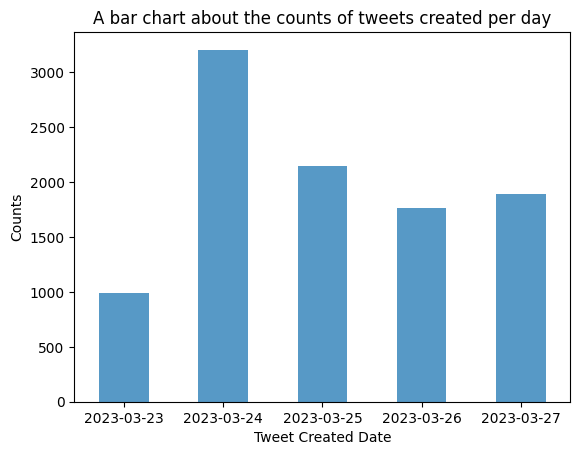

In [ ]:
# Plot a bar chart to show the counts of tweets created per day
tweets['tweet_created_date'].value_counts()[sorted(tweets.tweet_created_date.unique())].plot(kind= 'bar',alpha=0.75, rot=0)
plt.xlabel('Tweet Created Date')
plt.ylabel('Counts')
plt.title('A bar chart about the counts of tweets created per day')
plt.show()

In [ ]:
# the average number of words per tweet
sum = 0
n = 0
for row in tweets.tweet_text:
    sum += len(row.split())
    n += 1
print(sum/n)

17.4081


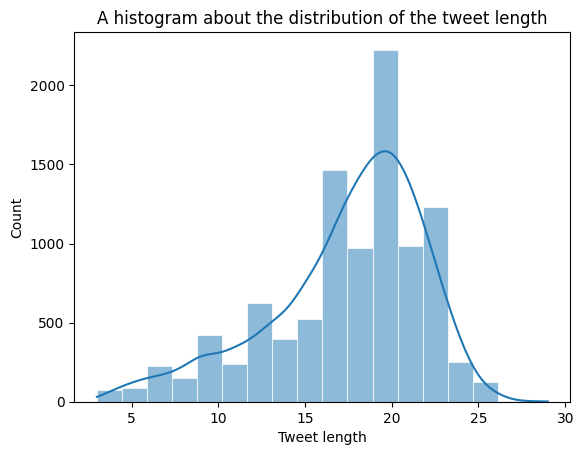

In [ ]:
# Plot
sns.histplot(tweets.tweet_text.apply(lambda row: len(row.split())), edgecolor='white', linewidth=0.5, kde=True, legend=False, bins=18)
plt.xlabel('Tweet length')
plt.title('A histogram about the distribution of the tweet length')
plt.show()

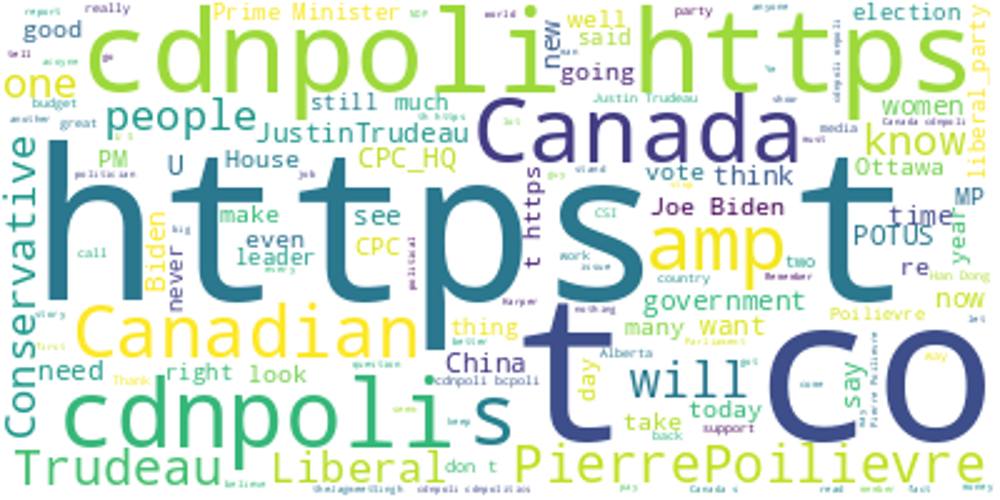

In [ ]:
# Word cloud of most common words
all_words = ','.join(list(tweets['tweet_text'].values))
wordcloud = WordCloud(background_color="white", max_words=1000)
wordcloud.generate(all_words)
wordcloud.to_image().resize((1000, 500))

In [ ]:
# Preprocess tweet_text
def remove_all_stopwords(df):
  sw = stopwords.words("english")
  df['tokens'] = df['tokens'].apply(lambda row: [w for w in row if w not in sw])

tokenize(tweets, "tweet_text")
remove_URL(tweets)
remove_punc(tweets)
lowercase(tweets)
lemmatization(tweets)
remove_all_stopwords(tweets)

In [ ]:
tweets = tweets[tweets.tokens.str.len() > 0]

In [ ]:
tweets.tokens.value_counts()

[instead, huge, profit, wealthy, ceo, worker, get, stretched, need, affordable, home, care, ou]    11
[im, calling, canada, premier, invest, quality, public, health, care, forprofit, clinic, join]      8
[seems, like, doesnt, know, rule, house, common]                                                    6
[really, part, understand]                                                                          6
[federal, budget, 2023, whats, biggest, concern, ahead, announcement]                               5
                                                                                                   ..
[shameful, persecution, posie, parker, new, zealand, spectator]                                     1
[well, dont, tell, stayed, much]                                                                    1
[fife, must, resign, today, treasonous, cld, led, civil, war, disgrace, journalis]                  1
[whats, going]                                                                    

Latent Dirichlet Allocation

In [ ]:
tfidf_vec = TfidfVectorizer(
      analyzer='word',
      tokenizer= override_fcn,
      preprocessor= override_fcn,
      token_pattern= None)

tf = tfidf_vec.fit_transform(tweets['tokens'])
feature_names = tfidf_vec.get_feature_names_out()
lda = LatentDirichletAllocation(n_components=4, max_iter=50, random_state=0, learning_method='online')
ldaModel = lda.fit(tf)

In [ ]:
for topic_idx, topic in enumerate(lda.components_):
        print(" ".join([feature_names[i] for i in topic.argsort()[:-30 - 1:-1]]))

biden woman doe trudeau canadian joe canada president minister doesnt say wa government conservative hotel federal prime ha stand u budget part people speech get room tax 2023 cabinet dinner
two money michael w common believe real isnt truth word seems true house done address canadian politician need fact allegation start political smith saying canada nation p level find wow
come visit thank canada bidens man opposition exactly coming power con minister lying old interesting taking thanks care health worst called queen 3 ottawa funeral immigration resign 2 person set
wa canada trudeau liberal ha canadian like conservative party time good people election interference dong dont u know want mp year see would news china one medium inquiry said right


In [ ]:
dictionary = Dictionary(tweets.tokens)
corpus = [dictionary.doc2bow(tweet) for tweet in tweets.tokens]

In [ ]:
# Topics range
topics_range = [4, 10, 15, 20, 30, 40, 50, 100]

Perplexity = {}

# iterate through number of topics
for k in topics_range:
      lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=k, passes=10)
      Perplexity[k] = lda_model.log_perplexity(corpus)

print(Perplexity)

{4: -8.581140070976259, 10: -8.948436264006203, 15: -10.971821834628443, 20: -11.847801014826432, 30: -13.579725859928846, 40: -15.365968030167858, 50: -17.12735469595712, 100: -29.33086991890415}


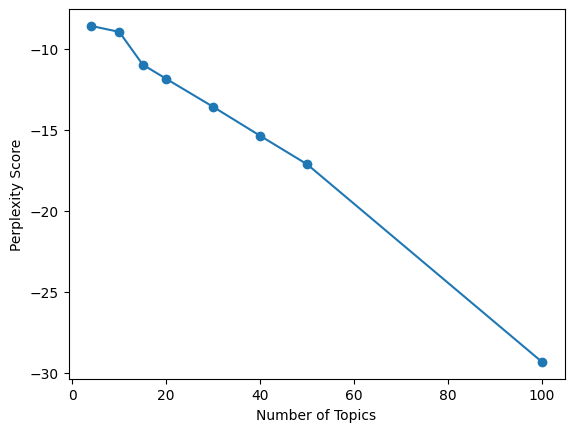

In [ ]:
plt.plot(Perplexity.keys(), Perplexity.values(), 'o-')
plt.xlabel("Number of Topics")
plt.ylabel("Perplexity Score")
plt.show()

In [ ]:
# Topics range
topics_range = [4, 10, 15, 20, 30, 40, 50, 100]

Coherence = {}

# iterate through number of topics
for k in topics_range:
      # get the coherence score for the given parameters
      lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=k, passes=10)
      coherence_model = CoherenceModel(model=lda_model, texts=tweets.tokens, dictionary=dictionary, coherence='c_v')
      Coherence[k] = coherence_model.get_coherence()

print(Coherence)

{4: 0.30874881592034104, 10: 0.2805752003846794, 15: 0.36647858043904075, 20: 0.3827531922395207, 30: 0.4636364346540216, 40: 0.5056333990057894, 50: 0.5268241117622999, 100: 0.5499020038803308}


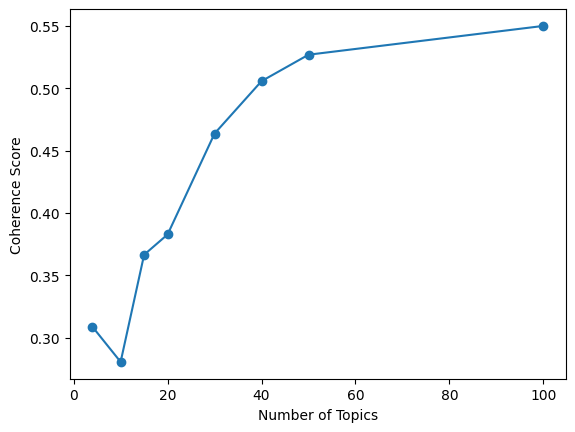

In [ ]:
plt.plot(Coherence.keys(), Coherence.values(), 'o-')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.show()

In [ ]:
# Train a LDA model with 50 topics
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=50, passes=10)
topics = lda_model.show_topics(num_topics=50, num_words=20, formatted=False)

In [ ]:
for i in range(50):
    print("Topic ", i+1, ":",  list(dict(topics[i][1]).keys()))

Topic  1 : ['great', 'con', 'care', 'calling', 'hear', 'canada', 'health', 'control', 'join', 'welcome', 'senior', 'premier', 'usa', 'guest', 'wa', 'sarah', 'peepee', 'dangerous', 'hill', 'doug']
Topic  2 : ['another', 'opposition', 'official', 'leader', 'police', 'attack', 'twitter', 'continues', '4', 'speaking', 'loyal', 'surprised', 'rate', 'wa', 'fake', 'al', 'majesty', 'hasnt', 'dropped', 'institution']
Topic  3 : ['minister', 'prime', 'truth', 'word', 'live', 'without', 'reporting', 'matter', 'north', 'nazi', 'finance', 'straight', 'get', 'v', 'peter', 'belief', 'shocked', 'one', 'corruption', 'covered']
Topic  4 : ['election', 'interference', 'h', 'national', 'chinese', 'taking', 'wa', 'bring', 'claim', 'journalist', 'far', 'canada', 'seem', 'bullshit', 'literally', 'class', 'met', 'china', 'canadian', 'would']
Topic  5 : ['like', 'doe', 'look', 'poilievre', 'right', 'pierre', 'way', 'parliament', 'nothing', 'getting', 'ha', 'canada', 'everything', 'medium', 'ontario', 'seems', 

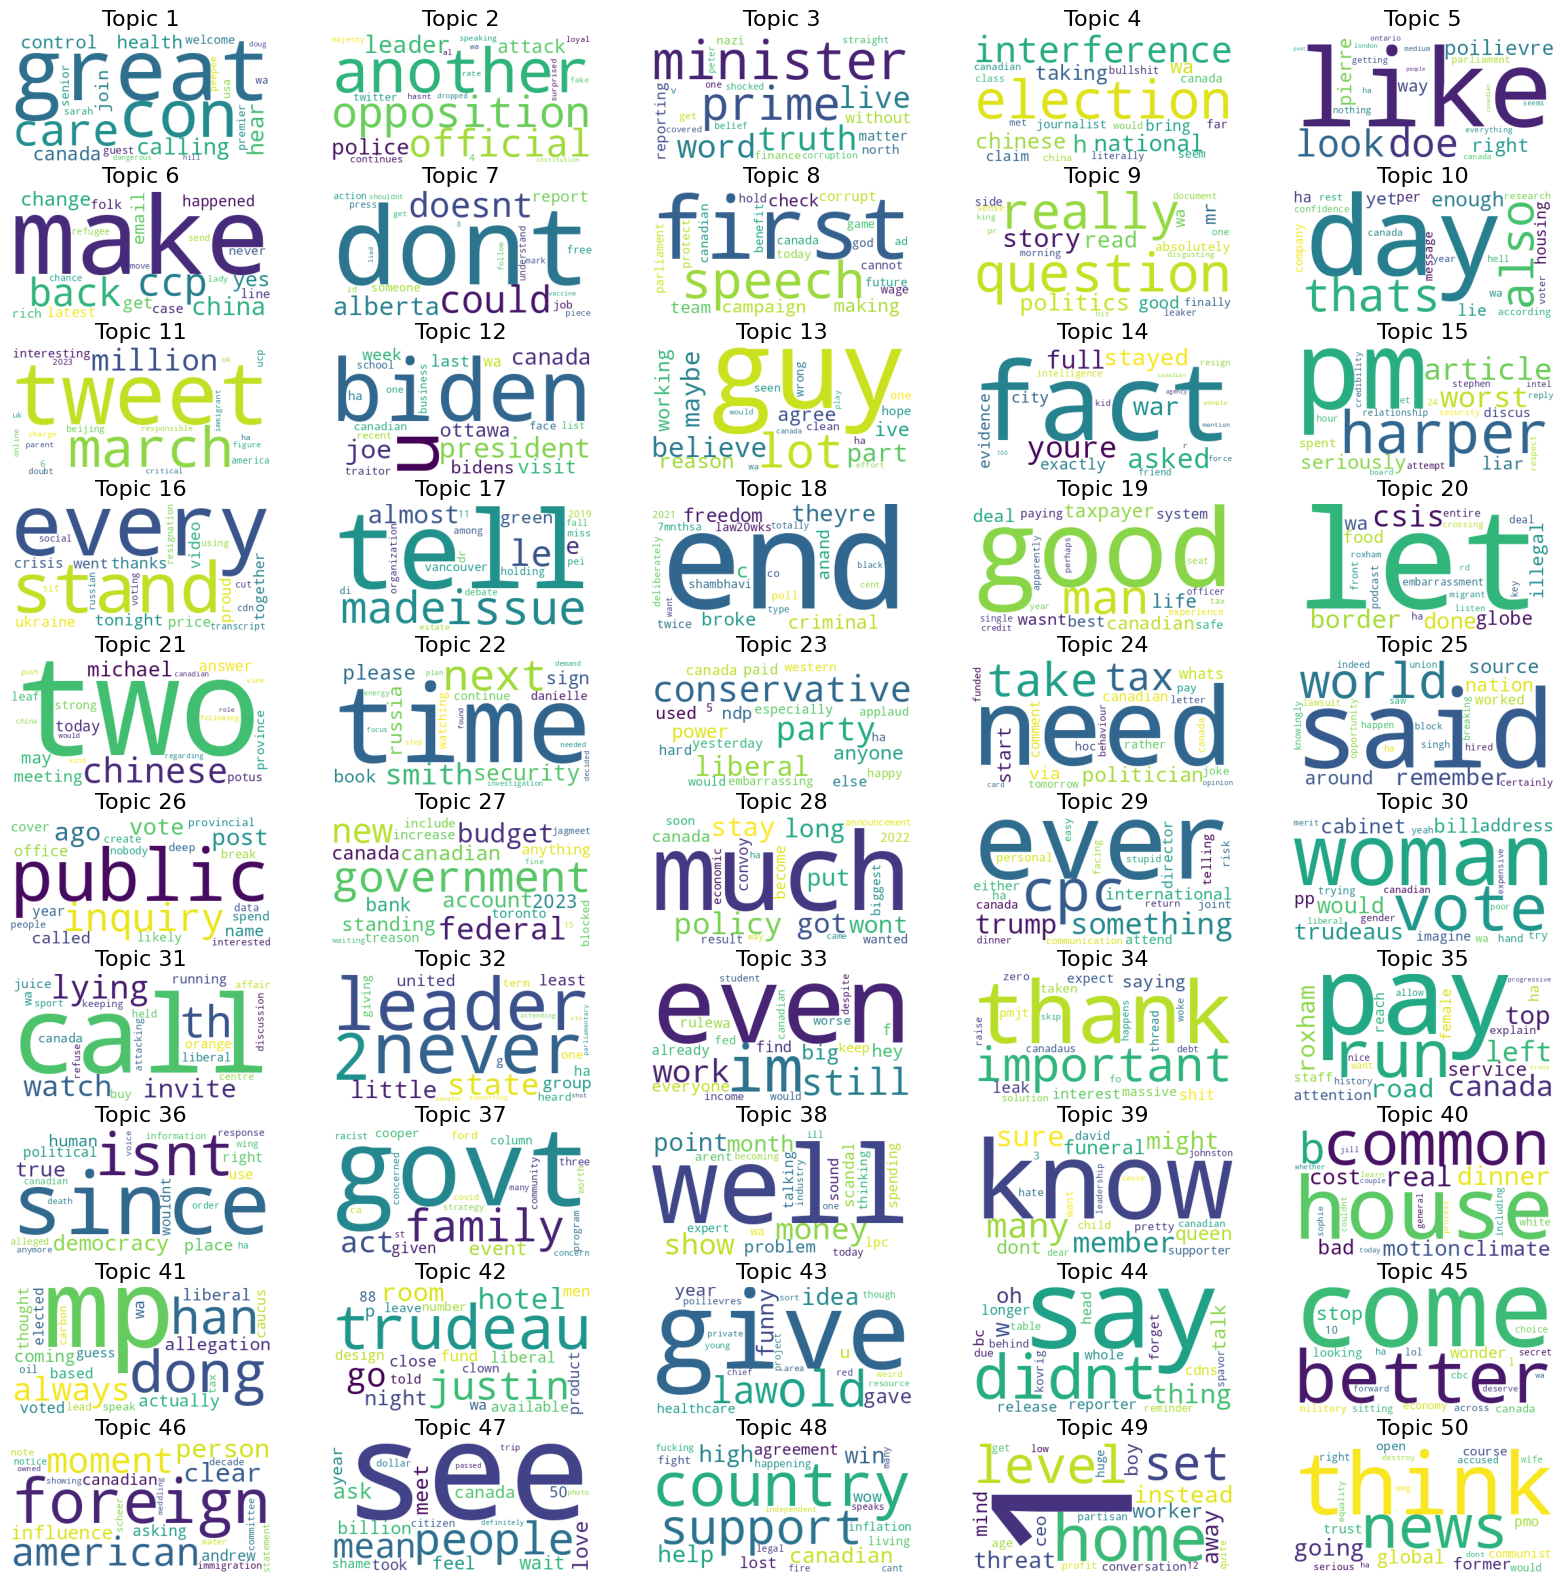

In [ ]:
cloud = WordCloud(background_color="white")

fig, axes=plt.subplots(10, 5, figsize=(20,20))
for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i+1), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.show()